Loading the csv file...
CSV file has been loaded
800000
800000
Analysis has started...
Memorizing the waveform at detector0...
Transforming the waveform at the detector 0...


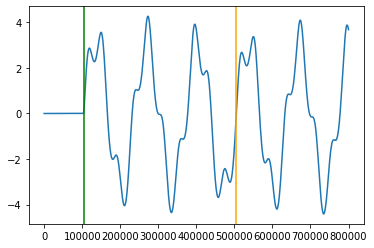

In [1]:
import yaml
from cProfile import label
import os
import sys
from os import times
from tokenize import cookie_re
from xmlrpc.client import boolean
from numpy.core.shape_base import atleast_2d
from numpy.lib import type_check
from scipy import fftpack
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal
from python_modules import FFT_utility as fu

with open("config.yaml", "r") as yml:
    config = yaml.safe_load(yml)

HPC_OR_LOCAL = "LOCAL"
imputFileName = "outp_1.csv"

print("Loading the csv file...")
data_raw = fu.loadCsvOutput(imputFileName)
print("CSV file has been loaded")

freq_f1 = config["f1"]  # GHz
"""Bigger frequency [GHz]"""
freq_f2 = config["f2"]
"""Smaller frequency [GHz]"""
freq_fsum = freq_f1+freq_f2
"""Frequency sum [GHz]"""
freq_fdif = freq_f1 - freq_f2
"""Frequency difference [GHz]"""
freq_fgcd = np.gcd(freq_f1, freq_f2)
"""Greatest common divisor of frequencies f1 and f2 [GHz]"""
source_amp_f1 = 1000/freq_f1/20  # A
"""Amplitude of f1 wave [Å]"""
source_amp_f2 = 1000/freq_f2/20  # A
"""Amplitude of f2 wave [Å]"""
#freq_index = 0
non_detec_cols = int(3)
# Nc doesnt have to be integer
Nc_fgcd = int(1)
Nc_f1 = Nc_fgcd*(freq_f1/freq_fgcd)
Nc_f2 = Nc_fgcd*(freq_f2/freq_fgcd)  # How many cycles to window
v_expt = 5500  # m/s
"""Experimental value of the longitudinal wave velocity [m/s]"""

T_f1 = 1000/freq_f1
"""wave f1's wave cycle [ps]"""
T_f2 = 1000/freq_f2
"""wave f1's wave cycle [ps]"""
T_fgcd = 1000/freq_fgcd
"""Least common multiple of the wave cycles T1 and T2 [ps]. Represents the wave cycle of f_gcd."""

data_raw_cols = data_raw.shape[1]
detecs_num = 1
# In most cases, data_raw[:,0] is time, data_raw[:,1] is source, data_raw[:,<last column>] is backend.

time = data_raw[:, 0]
timestep = time[1] - time[0]
print(int(time[-1]/timestep))
print(len(time)-1)

if (int(time[-1]/timestep) != len(time)-1):
    print("Data is possibly broken. Check if the data lacks information at some timestep.")
    sys.exit()
x_source = data_raw[:, 1]
x_detecs_array = data_raw[:, 2:2+detecs_num]
x_end = data_raw[:, 3]
# In most cases, data_raw[:,0] is time, data_raw[:,1] is source, data_raw[:,<last column>] is backend.
a_f1_at_detecs = np.zeros(detecs_num)
"""[m]"""
a_f2_at_detecs = np.zeros(detecs_num)
"""[m]"""
a_fsum_at_detecs = np.zeros(detecs_num)
"""[m]"""
a_fdif_at_detecs = np.zeros(detecs_num)
"""[m]"""

# not needed for freqmix
a_2f1_at_detecs = np.zeros(detecs_num)
"""[Å]"""
a_3f1_at_detecs = np.zeros(detecs_num)
"""[Å]"""
a_4f1_at_detecs = np.zeros(detecs_num)
"""[Å]"""

beta_SHGs_at_detecs = np.zeros(detecs_num)
beta_SHGs_at_detecs_corrected = np.zeros(detecs_num)
beta_sums_at_detecs = np.zeros(detecs_num)
beta_sums_at_detecs_corrected = np.zeros(detecs_num)
beta_difs_at_detecs = np.zeros(detecs_num)
beta_difs_at_detecs_corrected = np.zeros(detecs_num)
beta_aves_at_detecs = np.zeros(detecs_num)
beta_aves_at_detecs_corrected = np.zeros(detecs_num)

#betaSHGArrayCorrected = np.zeros((len(freqs_f_1), len(detecs)))

#wavelength_f1 = np.zeros(len(freqs_f_1))
#waveVelocityArray = np.zeros((len(freqs_f_1), len(detecs)))

Ns_f1 = T_f1/timestep  # Ns: Number of data points in one cycle
# N: Total Number of data points in thw windowed region
N_f1 = int(Nc_f1*Ns_f1)

Ns_f2 = T_f2/timestep  # Ns: Number of data points in one cycle
# N: Total Number of data points in thw windowed region
N_f2 = int(Nc_f2*Ns_f2)

Ns_fgcd = T_fgcd/timestep
N_fgcd = int(Nc_fgcd*Ns_fgcd)

if(N_f1 != N_f2 or N_f2 != N_fgcd or N_fgcd != N_f1):
    print("REVIEW YOUR INPUT. Program has gone into forced shutdown.")
    sys.exit()

u_detecs_array = x_detecs_array - x_detecs_array[0]

delta_x_source_detec0 = x_detecs_array[0, 0] - x_source[0]
if detecs_num >= 2:
    delta_x_detecs = x_detecs_array[0, 1] - x_detecs_array[0, 0]
    delta_t_detecs = delta_x_detecs/10*(10**3)/5500  # ps
trimmed_waves = np.zeros((detecs_num, N_fgcd))
windowed_waves = np.zeros((detecs_num, N_fgcd))
wave_velocity_at_detecs_array = np.zeros(detecs_num)
zerocross_timestep_at_detecs_array = np.zeros(detecs_num)
arrival_timestep_at_detecs_array = np.zeros(detecs_num)

print("Analysis has started...")
for i in range(detecs_num):
    print("Memorizing the waveform at detector"+str(i)+"...")
    x_detec = x_detecs_array[:, i]
    u_detec = u_detecs_array[:, i]
    delta_x_source_to_thisdetec = x_detec[0] - x_source[0]
    if "zerocross_start_rate" in config:
        zerocross_timestep, arrival_timestep, wave_velocity = fu.wave_arrival_zerocross(
            u_detec, delta_x_source_to_thisdetec, v_expt, timestep, T_fgcd, float(config["zerocross_start_rate"]))
    else:
        zerocross_timestep, arrival_timestep, wave_velocity = fu.wave_arrival_zerocross(
            u_detec, delta_x_source_to_thisdetec, v_expt, timestep, T_fgcd)
    wave_velocity_at_detecs_array[i] = wave_velocity
    zerocross_timestep_at_detecs_array[i] = zerocross_timestep
    arrival_timestep_at_detecs_array[i] = arrival_timestep
    plt.plot(u_detec)
    plt.axvline(x=zerocross_timestep, color="orange")
    plt.axvline(x=arrival_timestep, color="green")
    plt.savefig("waveform.png")

wave_velocity = wave_velocity_at_detecs_array[-1]
del zerocross_timestep
del arrival_timestep

wavelength_f1 = wave_velocity * T_f1 * (10**(-12))
"""[m]"""
wavelength_f2 = wave_velocity * T_f2 * (10**(-12))
"""[m]"""
k_f1 = 2*np.pi/wavelength_f1
"""[1/m]"""
k_f1 = 2*np.pi/wavelength_f1
"""[1/m]"""

# フーリエ変換
for i in range(detecs_num):
    # ゼロクロス法の音速測定
    # Δx_source_and_detec[A]*100[pm/A] / v[pm/ps] = Δt_source_and_detec [ps]
    # この時刻から半周期たった時（first positive peak）を基準に，そこからゼロクロス法を行う
    print("Transforming the waveform at the detector "+str(i)+"...")
    x_detec = x_detecs_array[:, i]
    u_detec = u_detecs_array[:, i]
    delta_x_source_to_thisdetec = x_detec[0] - x_source[0]

    window_start_timestep = int(
        zerocross_timestep_at_detecs_array[i] - 2*T_f2/timestep)


    # ここまで音速測定

    trimmedWave = u_detec[window_start_timestep:window_start_timestep+N_fgcd]
    trimmedTime = time[window_start_timestep:window_start_timestep+N_fgcd]

    windowedWave = fu.window(trimmedWave)
    #paddedWave = fu.zeroPadding(windowedWave)
    #paddedWaveWithoutWindow = fu.zeroPadding(trimmedWave)

    ##SUPER IMPORTANT##
    waveToTransform = windowedWave
    ##CHOU DAIJI##

    """if (i==detecs_num-2):
        plt.plot(time, u_detec)
        plt.axvline(x=window_start_timestep*timestep)
        plt.axvline(x=(window_start_timestep+N_fgcd)*timestep)
        plt.show()"""

    # FFT. transformedArray: [0]=power, [1]=freq
    # FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
    #FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
    ffted_data = fu.FFTonly(waveToTransform, timestep)
    #FFTedData=FFTonly(window(trimmedWave, "hann"))
    abs_ffted_data = np.abs(ffted_data)

    index_fsum = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fsum*10**9)
    A_fsum = abs_ffted_data[0][index_fsum]
    a_fsum = A_fsum*2/int(len(waveToTransform))*10**-10
    a_fsum_at_detecs[i] = a_fsum

    index_fdif = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fdif*10**9)
    A_fdif = abs_ffted_data[0][index_fdif]
    a_fdif = A_fdif*2/int(len(waveToTransform))*10**-10
    a_fdif_at_detecs[i] = a_fdif

    index_f1 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][index_f1]
    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    index_f2 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f2*10**9)
    A_f2 = abs_ffted_data[0][index_f2]
    a_f2 = A_f2 * 2/int(len(waveToTransform))*10**-10
    a_f2_at_detecs[i] = a_f2

    beta_mix = fu.getBetaFreqMix(a_fsum, a_fdif, source_amp_f1*10**-10, source_amp_f2*10**-10,
                                 freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity)
    beta_mix_corrected = fu.getBetaFreqMix(
        a_fsum, a_fdif, a_f1, a_f2, freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity_at_detecs_array[i])

    beta_sum = beta_mix[0]
    beta_sum_corrected = beta_mix_corrected[0]
    beta_sums_at_detecs[i] = beta_sum
    beta_sums_at_detecs_corrected[i] = beta_sum_corrected

    beta_dif = beta_mix[1]
    beta_dif_corrected = beta_mix_corrected[1]
    beta_difs_at_detecs[i] = beta_dif
    beta_difs_at_detecs_corrected[i] = beta_dif_corrected

    # higher harmonics amplitude[arb]
    harmonicsIndex = fu.getIndexUpToSixthHarmonic(
        abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][harmonicsIndex[0]]
    A_2f1 = abs_ffted_data[0][harmonicsIndex[1]]
    A_3f1 = abs_ffted_data[0][harmonicsIndex[2]]
    A_4f1 = abs_ffted_data[0][harmonicsIndex[3]]
    A_5f1 = abs_ffted_data[0][harmonicsIndex[4]]
    A_6f1 = abs_ffted_data[0][harmonicsIndex[5]]

    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    a_2f1 = A_2f1*2/int(len(waveToTransform))*10**-10
    a_2f1_at_detecs[i] = a_2f1

    a_3f1 = A_3f1*2/int(len(waveToTransform))*10**-10
    a_3f1_at_detecs[i] = a_3f1

    a_4f1 = A_4f1*2/int(len(waveToTransform))*10**-10
    a_4f1_at_detecs[i] = a_4f1

    a_f1_source = source_amp_f1*10**-10
    a_f2_source = source_amp_f2*10**-10

    beta_shg = fu.getBetaSHG(a_f1_source, a_2f1, wavelength_f1,
                             delta_x_source_to_thisdetec*(10**-10))
    beta_shg_corrected = fu.getBetaSHG(
        a_f1, a_2f1, wavelength_f1, delta_x_source_to_thisdetec*(10**-10))
    """with open("betaSHG.txt", "w") as f:
        f.write(str(betaSHG))
    """
    beta_SHGs_at_detecs[i] = beta_shg
    beta_SHGs_at_detecs_corrected[i] = beta_shg_corrected

    """if i == detecs_num-3:
        fig, ax = plt.subplots()
        ax.plot(trimmedTime, waveToTransform)
        plt.savefig("wave_of_detector_"+str(i)+".png", format="png")"""

Drawing the graphs at the right end detector...
beta_slope_sum
1.2389887146080405

beta_slope_dif
1.4088991297039077

average
1.3239439221559741


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


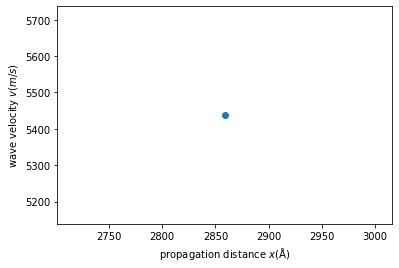

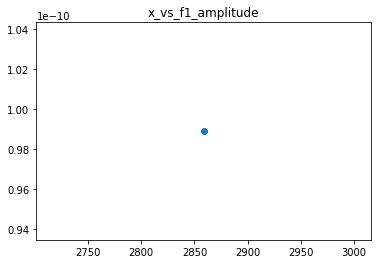

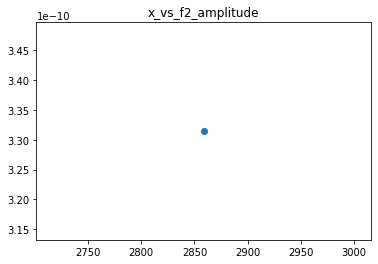

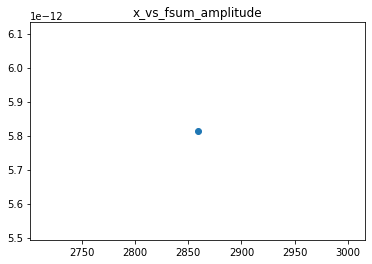

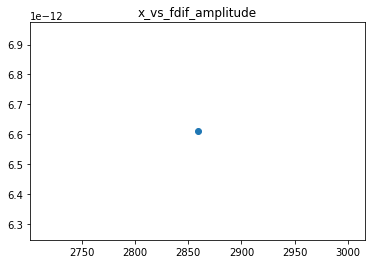

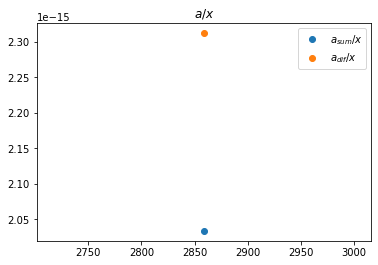

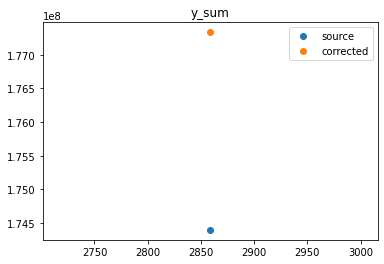

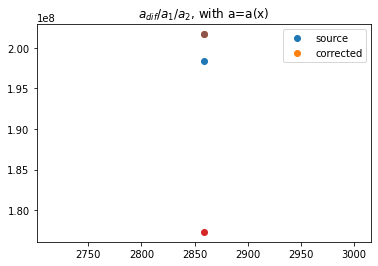

In [2]:
print("Drawing the graphs at the right end detector...")
beta_aves_at_detecs = (beta_sums_at_detecs + beta_difs_at_detecs)/2
beta_aves_at_detecs_corrected = (
    beta_sums_at_detecs_corrected + beta_difs_at_detecs_corrected)/2

fig, ax = plt.subplots()
ax.set_xlabel(r"propagation distance $x (\mathrm{\AA)}$ ")
ax.set_ylabel(r"wave velocity $v (m/s)$")
ax.plot(x_detecs_array[0], wave_velocity_at_detecs_array,
        marker="o", linestyle="none")
plt.savefig("x_vs_velocity.png")

fig, ax = plt.subplots()
title = "x_vs_f1_amplitude"
plt.plot(x_detecs_array[0, :], a_f1_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_f2_amplitude"
plt.plot(x_detecs_array[0, :], a_f2_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_fsum_amplitude"
plt.plot(x_detecs_array[0, :], a_fsum_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_fdif_amplitude"
plt.plot(x_detecs_array[0, :], a_fdif_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")


fig, ax = plt.subplots()
ax.set_title("$a/x$")
ax.plot(x_detecs_array[0, :], a_fsum_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none", label=r"$a_{sum}/x$")
ax.plot(x_detecs_array[0, :], a_fdif_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none", label=r"$a_{dif}/x$")
ax.legend()
plt.savefig("x_vs_a.png")


# slope method
y_sum_source = a_fsum_at_detecs/a_f1_source/a_f2_source
fig, ax = plt.subplots()
ax.plot(x_detecs_array[0, :], y_sum_source[:],
        marker="o", linestyle="none", label="source")

y_sum_corrected = a_fsum_at_detecs/a_f1_at_detecs/a_f2_at_detecs
ax.plot(x_detecs_array[0, :], y_sum_corrected[:],
        marker="o", linestyle="none", label="corrected")
title = "y_sum"
ax.set_title(title)
ax.legend()
plt.savefig(title+".png")

fig, ax = plt.subplots()
y_dif_source = a_fdif_at_detecs/a_f1_source/a_f2_source
ax.plot(x_detecs_array[0, :], y_dif_source[:],
        marker="o", linestyle="none", label="source")

y_dif_corrected = a_fdif_at_detecs/a_f1_at_detecs/a_f2_at_detecs
ax.plot(x_detecs_array[0, :], y_dif_corrected[:],
        marker="o", linestyle="none", label="corrected")
title = "y_dif"
ax.set_title(title)
ax.legend()
plt.savefig(title+".png")
# detector 0からM-1 が外れ値をとっている場合がある．その場合N以降でslopeを取ったほうが良い．
# 外れていない場合は M=0

N = 0
res_sum = np.polyfit(
    x_detecs_array[0, N:], y_sum_corrected[N:], 1)
linear = np.poly1d(res_sum)(x_detecs_array[0, N:])
plt.plot(x_detecs_array[0, N:], linear)
plt.plot(x_detecs_array[0, N:], y_sum_corrected[N:],
         marker="o", linestyle="none")
plt.title("$a_{sum}/a_1/a_2$, with a=a(x)")
plt.savefig("ysum_linear_fit.png")
# print(res_sum[0])
beta_slope_sum = res_sum[0]*4*wavelength_f1*wavelength_f2*10**10/4/np.pi**2
print("beta_slope_sum")
print(beta_slope_sum)
print()
with open("beta.csv", mode='a') as f:
    f.write(str(beta_slope_sum))

M = 0
res_dif = np.polyfit(
    x_detecs_array[0, M:], y_dif_corrected[M:], 1)
linear = np.poly1d(res_dif)(x_detecs_array[0, M:])
plt.plot(x_detecs_array[0, M:], linear)
plt.plot(x_detecs_array[0, M:], y_dif_corrected[M:],
         marker="o", linestyle="none")
plt.title("$a_{dif}/a_1/a_2$, with a=a(x)")
plt.savefig("ydif_linear_fit.png")
# print(res_dif[0])
beta_slope_dif = res_dif[0]*4*wavelength_f1*wavelength_f2*10**10/4/np.pi**2
print("beta_slope_dif")
print(beta_slope_dif)
print()
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_slope_dif))

print("average")
beta_slope_ave = (beta_slope_dif+beta_slope_sum)/2
print(beta_slope_ave)
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_slope_ave))

beta_sum_rightend_detec, corrected
2.4784960318844673
beta_sum_rightend_detec, raw
2.437463606834488
beta_ave_rightend_detec, corrected
2.6484420066241054
beta_ave_rightend_detec, raw
2.604596062657274
beta_dif_rightend_detec, corrected
2.8183879813637436
beta_ave_rightend_detec, raw
2.77172851848006


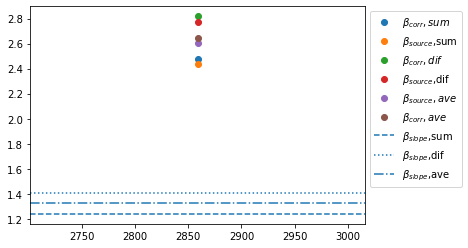

In [3]:
print("beta_sum_rightend_detec, corrected")
print(beta_sums_at_detecs_corrected[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_sums_at_detecs_corrected[-1]))

with open("beta_sum_corr.txt", mode="w") as f:
    f.write(str(beta_sums_at_detecs_corrected[-1]))

print("beta_sum_rightend_detec, raw")
print(beta_sums_at_detecs[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_sums_at_detecs[-1]))

print("beta_ave_rightend_detec, corrected")
print((beta_difs_at_detecs_corrected[-1]+beta_sums_at_detecs_corrected[-1])/2)
with open("beta.csv", mode='a') as f:
    f.write(
        ","+str((beta_difs_at_detecs_corrected[-1]+beta_sums_at_detecs_corrected[-1])/2))

print("beta_ave_rightend_detec, raw")
print((beta_sums_at_detecs[-1]+beta_difs_at_detecs[-1])/2)
with open("beta.csv", mode='a') as f:
    f.write(","+str((beta_sums_at_detecs[-1]+beta_difs_at_detecs[-1])/2))

print("beta_dif_rightend_detec, corrected")
print(beta_difs_at_detecs_corrected[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_difs_at_detecs_corrected[-1]))

print("beta_ave_rightend_detec, raw")
print(beta_difs_at_detecs[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_difs_at_detecs[-1]))

fig, ax = plt.subplots()

ax.plot(x_detecs_array[0, :], beta_sums_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},sum$")
ax.plot(x_detecs_array[0, :], beta_sums_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,sum")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},dif$")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,dif")
ax.plot(x_detecs_array[0, :], beta_aves_at_detecs,
        marker="o", linestyle="none", label=r"$\beta _{source},ave$")
ax.plot(x_detecs_array[0, :], beta_aves_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},ave$")
ax.axhline(y=beta_slope_sum, linestyle="--",
           label=r"$\beta _{slope}$,sum")
ax.axhline(y=beta_slope_dif, linestyle=":",
           label=r"$\beta _{slope}$,dif")
ax.axhline(y=beta_slope_ave, linestyle="dashdot",
           label=r"$\beta _{slope}$,ave")
# ax.set_xlim([400,699])
#ax.set_ylim([2, 3.5])
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("betas_vs_x.png", bbox_inches="tight")

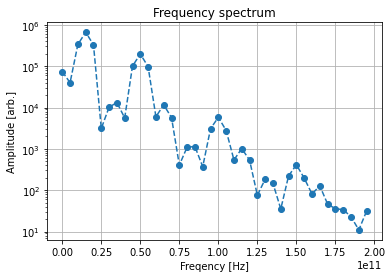

In [4]:
i = int(-1)
# ゼロクロス法の音速測定
# Δx_source_and_detec[A]*100[pm/A] / v[pm/ps] = Δt_source_and_detec [ps]
# この時刻から半周期たった時（first positive peak）を基準に，そこからゼロクロス法を行う
x_detec = x_detecs_array[:, i]
u_detec = u_detecs_array[:, i]
delta_x_source_to_thisdetec = x_detec[0] - x_source[0]

window_start_timestep = int(
    zerocross_timestep_at_detecs_array[i] - 2*T_f2/timestep)

# ここまで音速測定

trimmedWave = u_detec[window_start_timestep:window_start_timestep+N_fgcd]
trimmedTime = time[window_start_timestep:window_start_timestep+N_fgcd]

windowedWave = fu.window(trimmedWave, "hann")
#paddedWave = fu.zeroPadding(windowedWave)
#paddedWaveWithoutWindow = fu.zeroPadding(trimmedWave)

##SUPER IMPORTANT##
waveToTransform = windowedWave
##CHOU DAIJI##

"""if (i==detecs_num-2):
    plt.plot(time, u_detec)
    plt.axvline(x=window_start_timestep*timestep)
    plt.axvline(x=(window_start_timestep+N_fgcd)*timestep)
    plt.show()"""

# FFT. transformedArray: [0]=power, [1]=freq
# FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
#FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
ffted_data = fu.FFTonly(waveToTransform, timestep)
#FFTedData=FFTonly(window(trimmedWave, "hann"))
abs_ffted_data = np.abs(ffted_data)

index_fsum = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fsum*10**9)
A_fsum = abs_ffted_data[0][index_fsum]
a_fsum = A_fsum*2/int(len(waveToTransform))*10**-10
a_fsum_at_detecs[i] = a_fsum

index_fdif = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fdif*10**9)
A_fdif = abs_ffted_data[0][index_fdif]
a_fdif = A_fdif*2/int(len(waveToTransform))*10**-10
a_fdif_at_detecs[i] = a_fdif

index_f1 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f1*10**9)
A_f1 = abs_ffted_data[0][index_f1]
a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
a_f1_at_detecs[i] = a_f1

index_f2 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f2*10**9)
A_f2 = abs_ffted_data[0][index_f2]
a_f2 = A_f2 * 2/int(len(waveToTransform))*10**-10
a_f2_at_detecs[i] = a_f2

beta_mix = fu.getBetaFreqMix(a_fsum, a_fdif, source_amp_f1*10**-10, source_amp_f2*10**-10,
                             freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity)
beta_mix_corrected = fu.getBetaFreqMix(
    a_fsum, a_fdif, a_f1, a_f2, freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity_at_detecs_array[i])

beta_sum = beta_mix[0]
beta_sum_corrected = beta_mix_corrected[0]
beta_sums_at_detecs[i] = beta_sum
beta_sums_at_detecs_corrected[i] = beta_sum_corrected

beta_dif = beta_mix[1]
beta_dif_corrected = beta_mix_corrected[1]
beta_difs_at_detecs[i] = beta_dif
beta_difs_at_detecs_corrected[i] = beta_dif_corrected

# higher harmonics amplitude[arb]
harmonicsIndex = fu.getIndexUpToSixthHarmonic(
    abs_ffted_data[1], freq_f1*10**9)
A_f1 = abs_ffted_data[0][harmonicsIndex[0]]
A_2f1 = abs_ffted_data[0][harmonicsIndex[1]]
A_3f1 = abs_ffted_data[0][harmonicsIndex[2]]
A_4f1 = abs_ffted_data[0][harmonicsIndex[3]]
A_5f1 = abs_ffted_data[0][harmonicsIndex[4]]
A_6f1 = abs_ffted_data[0][harmonicsIndex[5]]

a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
a_f1_at_detecs[i] = a_f1

a_2f1 = A_2f1*2/int(len(waveToTransform))*10**-10
a_2f1_at_detecs[i] = a_2f1

a_3f1 = A_3f1*2/int(len(waveToTransform))*10**-10
a_3f1_at_detecs[i] = a_3f1

a_4f1 = A_4f1*2/int(len(waveToTransform))*10**-10
a_4f1_at_detecs[i] = a_4f1

a_f1_source = source_amp_f1*10**-10
a_f2_source = source_amp_f2*10**-10

beta_shg = fu.getBetaSHG(a_f1_source, a_2f1, wavelength_f1,
                         delta_x_source_to_thisdetec*(10**-10))
beta_shg_corrected = fu.getBetaSHG(
    a_f1, a_2f1, wavelength_f1, delta_x_source_to_thisdetec*(10**-10))
"""with open("betaSHG.txt", "w") as f:
    f.write(str(betaSHG))
"""
beta_SHGs_at_detecs[i] = beta_shg
beta_SHGs_at_detecs_corrected[i] = beta_shg_corrected

fig, ax = plt.subplots()
ax.set_yscale("log")
#ax.plot(absFFTData[1,1:int(N/2)], absFFTData[0,1:int(N/2)])
ax.plot(abs_ffted_data[1, 0:fu.getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1*10**9, freq_f2*10**9))*4],
        abs_ffted_data[0, 0:fu.getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1*10**9, freq_f2*10**9))*4], marker="o", linestyle="--")
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude [arb.]")
ax.grid()
plt.title("Frequency spectrum")
plt.savefig("freq_spectrum_rightend_detector.png")

In [5]:
x_detec[1]

2858.85538956986

In [6]:
x_detec[0]

2858.85538956986

In [7]:
x_detec.shape

(800001,)

In [8]:
max(x_detec)

2863.12861122658

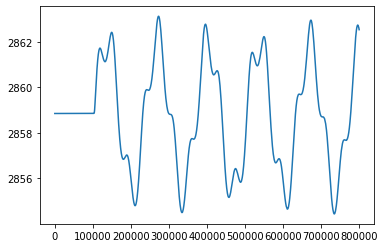

In [9]:
plt.plot(x_detec)
plt.show()

In [10]:
max(u_detec)

4.27322165671967

In [11]:
max(u_detec[300000:400000])

3.9252722146898122

In [12]:
u_detec[300000:400000].index(max(u_detec[300000:400000]))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [13]:
print(np.where(u_detec[300000:400000]==max(u_detec[300000:400000])))

(array([96048]),)


In [14]:
print(np.where(u_detec==max(u_detec[300000:400000])))

(array([396048]),)


In [15]:
print(np.where(u_detec==max(u_detec[700000:])))

(array([796239]),)


In [16]:
max(u_detec[300000:400000])

3.9252722146898122

In [17]:
max(u_detec[700000:])

3.8868192250897664

In [18]:
henkano_wariai = (3.9252722146898122-3.8868192250897664)/(796239-396048)

In [19]:
henkano_wariai

9.608659265212321e-08

In [20]:
arrival_timestep_at_detecs_array

array([105124.])

In [21]:
u_detec[105124]

0.2705054807797751

In [22]:
hosei=np.zeros(800001)

In [23]:
hosei

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
hoset.shape

NameError: name 'hoset' is not defined

In [25]:
hosei.shape

(800001,)

In [26]:
for i in range(105124,800002):
    x=0
    hosei[i]=henkano_wariai*x
    x=x+1


IndexError: index 800001 is out of bounds for axis 0 with size 800001

In [27]:
for i in range(105124,800001):
    x=0
    hosei[i]=henkano_wariai*x
    x=x+1


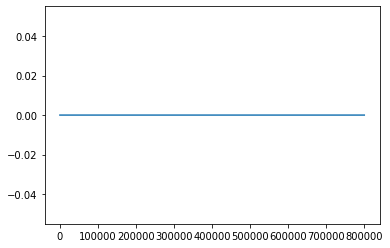

In [28]:
plt.plot(hosei)
plt.show()

In [29]:
hosei[01]

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-29-a8bb7ae15a7f>, line 1)

In [30]:
hosei[1]

0.0

In [31]:
hosei[-1]

0.0

In [32]:
for i in range(105124,800001):
    x=0.0
    hosei[i]=henkano_wariai*x
    x=x+1


In [33]:
hosei[-1]

0.0

In [34]:
henkano_wariai

9.608659265212321e-08

In [35]:
henkano_wariai*600000

0.05765195559127392

In [36]:
hosei[0]

0.0

In [37]:
hosei[600000]

0.0

In [38]:
for i in range(105124,800001):
    x=0.0
    hosei[i]=henkano_wariai*x
    x=x+1
    print(x)


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


KeyboardInterrupt: 

In [39]:
x=0.0
for i in range(105124,800001):
    hosei[i]=henkano_wariai*x
    x=x+1

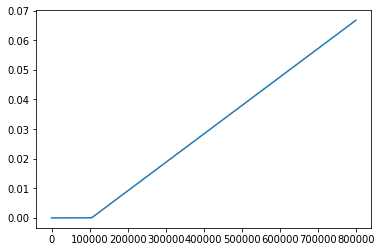

In [40]:
plt.plot(hosei)
plt.show()

In [41]:
x_detec = x_detec+hosei

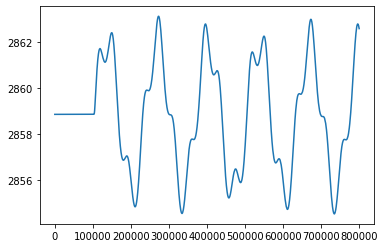

In [42]:
plt.plot(x_detec)
plt.show()

In [43]:
x_detecs_array.shape

(800001, 1)

In [44]:
x_detecs_array[:,0]=x_detec

In [45]:
# フーリエ変換
for i in range(detecs_num):
    # ゼロクロス法の音速測定
    # Δx_source_and_detec[A]*100[pm/A] / v[pm/ps] = Δt_source_and_detec [ps]
    # この時刻から半周期たった時（first positive peak）を基準に，そこからゼロクロス法を行う
    print("Transforming the waveform at the detector "+str(i)+"...")
    x_detec = x_detecs_array[:, i]
    u_detec = u_detecs_array[:, i]
    delta_x_source_to_thisdetec = x_detec[0] - x_source[0]

    window_start_timestep = int(
        zerocross_timestep_at_detecs_array[i] - 2*T_f2/timestep)


    # ここまで音速測定

    trimmedWave = u_detec[window_start_timestep:window_start_timestep+N_fgcd]
    trimmedTime = time[window_start_timestep:window_start_timestep+N_fgcd]

    windowedWave = fu.window(trimmedWave)
    #paddedWave = fu.zeroPadding(windowedWave)
    #paddedWaveWithoutWindow = fu.zeroPadding(trimmedWave)

    ##SUPER IMPORTANT##
    waveToTransform = windowedWave
    ##CHOU DAIJI##

    """if (i==detecs_num-2):
        plt.plot(time, u_detec)
        plt.axvline(x=window_start_timestep*timestep)
        plt.axvline(x=(window_start_timestep+N_fgcd)*timestep)
        plt.show()"""

    # FFT. transformedArray: [0]=power, [1]=freq
    # FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
    #FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
    ffted_data = fu.FFTonly(waveToTransform, timestep)
    #FFTedData=FFTonly(window(trimmedWave, "hann"))
    abs_ffted_data = np.abs(ffted_data)

    index_fsum = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fsum*10**9)
    A_fsum = abs_ffted_data[0][index_fsum]
    a_fsum = A_fsum*2/int(len(waveToTransform))*10**-10
    a_fsum_at_detecs[i] = a_fsum

    index_fdif = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fdif*10**9)
    A_fdif = abs_ffted_data[0][index_fdif]
    a_fdif = A_fdif*2/int(len(waveToTransform))*10**-10
    a_fdif_at_detecs[i] = a_fdif

    index_f1 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][index_f1]
    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    index_f2 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f2*10**9)
    A_f2 = abs_ffted_data[0][index_f2]
    a_f2 = A_f2 * 2/int(len(waveToTransform))*10**-10
    a_f2_at_detecs[i] = a_f2

    beta_mix = fu.getBetaFreqMix(a_fsum, a_fdif, source_amp_f1*10**-10, source_amp_f2*10**-10,
                                 freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity)
    beta_mix_corrected = fu.getBetaFreqMix(
        a_fsum, a_fdif, a_f1, a_f2, freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity_at_detecs_array[i])

    beta_sum = beta_mix[0]
    beta_sum_corrected = beta_mix_corrected[0]
    beta_sums_at_detecs[i] = beta_sum
    beta_sums_at_detecs_corrected[i] = beta_sum_corrected

    beta_dif = beta_mix[1]
    beta_dif_corrected = beta_mix_corrected[1]
    beta_difs_at_detecs[i] = beta_dif
    beta_difs_at_detecs_corrected[i] = beta_dif_corrected

    # higher harmonics amplitude[arb]
    harmonicsIndex = fu.getIndexUpToSixthHarmonic(
        abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][harmonicsIndex[0]]
    A_2f1 = abs_ffted_data[0][harmonicsIndex[1]]
    A_3f1 = abs_ffted_data[0][harmonicsIndex[2]]
    A_4f1 = abs_ffted_data[0][harmonicsIndex[3]]
    A_5f1 = abs_ffted_data[0][harmonicsIndex[4]]
    A_6f1 = abs_ffted_data[0][harmonicsIndex[5]]

    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    a_2f1 = A_2f1*2/int(len(waveToTransform))*10**-10
    a_2f1_at_detecs[i] = a_2f1

    a_3f1 = A_3f1*2/int(len(waveToTransform))*10**-10
    a_3f1_at_detecs[i] = a_3f1

    a_4f1 = A_4f1*2/int(len(waveToTransform))*10**-10
    a_4f1_at_detecs[i] = a_4f1

    a_f1_source = source_amp_f1*10**-10
    a_f2_source = source_amp_f2*10**-10

    beta_shg = fu.getBetaSHG(a_f1_source, a_2f1, wavelength_f1,
                             delta_x_source_to_thisdetec*(10**-10))
    beta_shg_corrected = fu.getBetaSHG(
        a_f1, a_2f1, wavelength_f1, delta_x_source_to_thisdetec*(10**-10))
    """with open("betaSHG.txt", "w") as f:
        f.write(str(betaSHG))
    """
    beta_SHGs_at_detecs[i] = beta_shg
    beta_SHGs_at_detecs_corrected[i] = beta_shg_corrected

    """if i == detecs_num-3:
        fig, ax = plt.subplots()
        ax.plot(trimmedTime, waveToTransform)
        plt.savefig("wave_of_detector_"+str(i)+".png", format="png")"""

Transforming the waveform at the detector 0...


Drawing the graphs at the right end detector...
beta_slope_sum
1.2389887146080405

beta_slope_dif
1.4088991297039077

average
1.3239439221559741


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


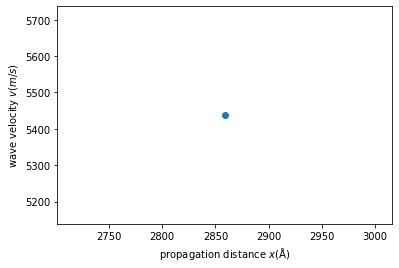

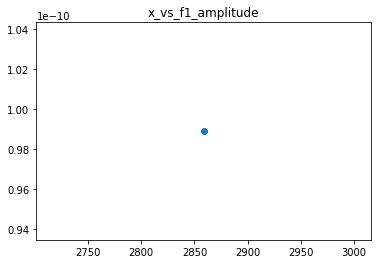

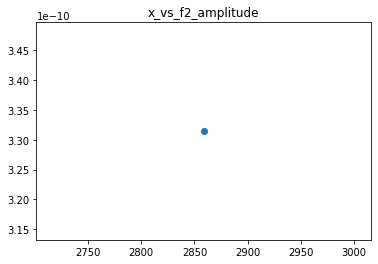

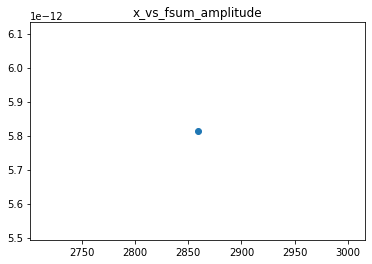

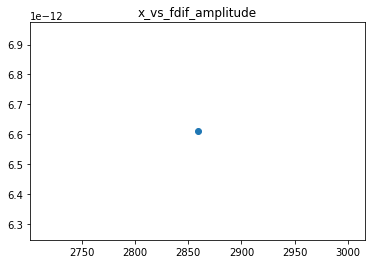

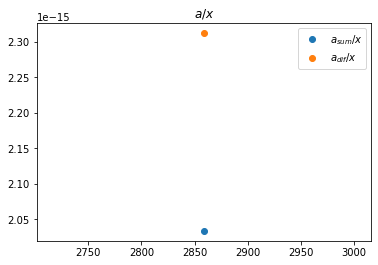

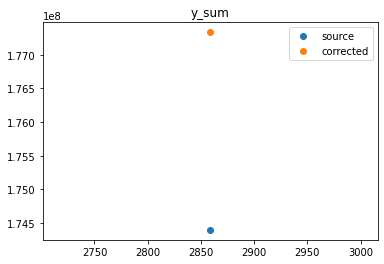

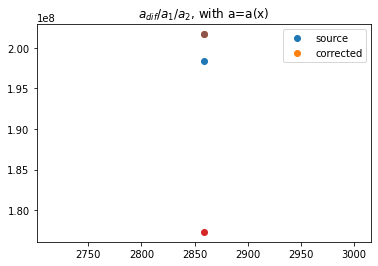

In [46]:
print("Drawing the graphs at the right end detector...")
beta_aves_at_detecs = (beta_sums_at_detecs + beta_difs_at_detecs)/2
beta_aves_at_detecs_corrected = (
    beta_sums_at_detecs_corrected + beta_difs_at_detecs_corrected)/2

fig, ax = plt.subplots()
ax.set_xlabel(r"propagation distance $x (\mathrm{\AA)}$ ")
ax.set_ylabel(r"wave velocity $v (m/s)$")
ax.plot(x_detecs_array[0], wave_velocity_at_detecs_array,
        marker="o", linestyle="none")
plt.savefig("x_vs_velocity.png")

fig, ax = plt.subplots()
title = "x_vs_f1_amplitude"
plt.plot(x_detecs_array[0, :], a_f1_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_f2_amplitude"
plt.plot(x_detecs_array[0, :], a_f2_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_fsum_amplitude"
plt.plot(x_detecs_array[0, :], a_fsum_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_fdif_amplitude"
plt.plot(x_detecs_array[0, :], a_fdif_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")


fig, ax = plt.subplots()
ax.set_title("$a/x$")
ax.plot(x_detecs_array[0, :], a_fsum_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none", label=r"$a_{sum}/x$")
ax.plot(x_detecs_array[0, :], a_fdif_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none", label=r"$a_{dif}/x$")
ax.legend()
plt.savefig("x_vs_a.png")


# slope method
y_sum_source = a_fsum_at_detecs/a_f1_source/a_f2_source
fig, ax = plt.subplots()
ax.plot(x_detecs_array[0, :], y_sum_source[:],
        marker="o", linestyle="none", label="source")

y_sum_corrected = a_fsum_at_detecs/a_f1_at_detecs/a_f2_at_detecs
ax.plot(x_detecs_array[0, :], y_sum_corrected[:],
        marker="o", linestyle="none", label="corrected")
title = "y_sum"
ax.set_title(title)
ax.legend()
plt.savefig(title+".png")

fig, ax = plt.subplots()
y_dif_source = a_fdif_at_detecs/a_f1_source/a_f2_source
ax.plot(x_detecs_array[0, :], y_dif_source[:],
        marker="o", linestyle="none", label="source")

y_dif_corrected = a_fdif_at_detecs/a_f1_at_detecs/a_f2_at_detecs
ax.plot(x_detecs_array[0, :], y_dif_corrected[:],
        marker="o", linestyle="none", label="corrected")
title = "y_dif"
ax.set_title(title)
ax.legend()
plt.savefig(title+".png")
# detector 0からM-1 が外れ値をとっている場合がある．その場合N以降でslopeを取ったほうが良い．
# 外れていない場合は M=0

N = 0
res_sum = np.polyfit(
    x_detecs_array[0, N:], y_sum_corrected[N:], 1)
linear = np.poly1d(res_sum)(x_detecs_array[0, N:])
plt.plot(x_detecs_array[0, N:], linear)
plt.plot(x_detecs_array[0, N:], y_sum_corrected[N:],
         marker="o", linestyle="none")
plt.title("$a_{sum}/a_1/a_2$, with a=a(x)")
plt.savefig("ysum_linear_fit.png")
# print(res_sum[0])
beta_slope_sum = res_sum[0]*4*wavelength_f1*wavelength_f2*10**10/4/np.pi**2
print("beta_slope_sum")
print(beta_slope_sum)
print()
with open("beta.csv", mode='a') as f:
    f.write(str(beta_slope_sum))

M = 0
res_dif = np.polyfit(
    x_detecs_array[0, M:], y_dif_corrected[M:], 1)
linear = np.poly1d(res_dif)(x_detecs_array[0, M:])
plt.plot(x_detecs_array[0, M:], linear)
plt.plot(x_detecs_array[0, M:], y_dif_corrected[M:],
         marker="o", linestyle="none")
plt.title("$a_{dif}/a_1/a_2$, with a=a(x)")
plt.savefig("ydif_linear_fit.png")
# print(res_dif[0])
beta_slope_dif = res_dif[0]*4*wavelength_f1*wavelength_f2*10**10/4/np.pi**2
print("beta_slope_dif")
print(beta_slope_dif)
print()
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_slope_dif))

print("average")
beta_slope_ave = (beta_slope_dif+beta_slope_sum)/2
print(beta_slope_ave)
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_slope_ave))

beta_sum_rightend_detec, corrected
2.4784960318844673
beta_sum_rightend_detec, raw
2.437463606834488
beta_ave_rightend_detec, corrected
2.6484420066241054
beta_ave_rightend_detec, raw
2.604596062657274
beta_dif_rightend_detec, corrected
2.8183879813637436
beta_ave_rightend_detec, raw
2.77172851848006


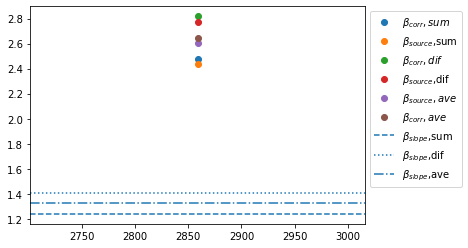

In [47]:
print("beta_sum_rightend_detec, corrected")
print(beta_sums_at_detecs_corrected[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_sums_at_detecs_corrected[-1]))

with open("beta_sum_corr.txt", mode="w") as f:
    f.write(str(beta_sums_at_detecs_corrected[-1]))

print("beta_sum_rightend_detec, raw")
print(beta_sums_at_detecs[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_sums_at_detecs[-1]))

print("beta_ave_rightend_detec, corrected")
print((beta_difs_at_detecs_corrected[-1]+beta_sums_at_detecs_corrected[-1])/2)
with open("beta.csv", mode='a') as f:
    f.write(
        ","+str((beta_difs_at_detecs_corrected[-1]+beta_sums_at_detecs_corrected[-1])/2))

print("beta_ave_rightend_detec, raw")
print((beta_sums_at_detecs[-1]+beta_difs_at_detecs[-1])/2)
with open("beta.csv", mode='a') as f:
    f.write(","+str((beta_sums_at_detecs[-1]+beta_difs_at_detecs[-1])/2))

print("beta_dif_rightend_detec, corrected")
print(beta_difs_at_detecs_corrected[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_difs_at_detecs_corrected[-1]))

print("beta_ave_rightend_detec, raw")
print(beta_difs_at_detecs[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_difs_at_detecs[-1]))

fig, ax = plt.subplots()

ax.plot(x_detecs_array[0, :], beta_sums_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},sum$")
ax.plot(x_detecs_array[0, :], beta_sums_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,sum")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},dif$")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,dif")
ax.plot(x_detecs_array[0, :], beta_aves_at_detecs,
        marker="o", linestyle="none", label=r"$\beta _{source},ave$")
ax.plot(x_detecs_array[0, :], beta_aves_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},ave$")
ax.axhline(y=beta_slope_sum, linestyle="--",
           label=r"$\beta _{slope}$,sum")
ax.axhline(y=beta_slope_dif, linestyle=":",
           label=r"$\beta _{slope}$,dif")
ax.axhline(y=beta_slope_ave, linestyle="dashdot",
           label=r"$\beta _{slope}$,ave")
# ax.set_xlim([400,699])
#ax.set_ylim([2, 3.5])
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("betas_vs_x.png", bbox_inches="tight")

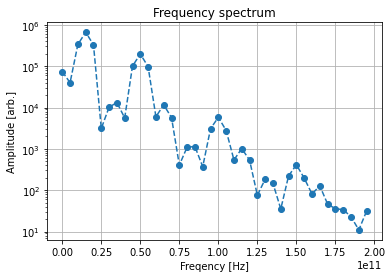

In [48]:
i = int(-1)
# ゼロクロス法の音速測定
# Δx_source_and_detec[A]*100[pm/A] / v[pm/ps] = Δt_source_and_detec [ps]
# この時刻から半周期たった時（first positive peak）を基準に，そこからゼロクロス法を行う
x_detec = x_detecs_array[:, i]
u_detec = u_detecs_array[:, i]
delta_x_source_to_thisdetec = x_detec[0] - x_source[0]

window_start_timestep = int(
    zerocross_timestep_at_detecs_array[i] - 2*T_f2/timestep)

# ここまで音速測定

trimmedWave = u_detec[window_start_timestep:window_start_timestep+N_fgcd]
trimmedTime = time[window_start_timestep:window_start_timestep+N_fgcd]

windowedWave = fu.window(trimmedWave, "hann")
#paddedWave = fu.zeroPadding(windowedWave)
#paddedWaveWithoutWindow = fu.zeroPadding(trimmedWave)

##SUPER IMPORTANT##
waveToTransform = windowedWave
##CHOU DAIJI##

"""if (i==detecs_num-2):
    plt.plot(time, u_detec)
    plt.axvline(x=window_start_timestep*timestep)
    plt.axvline(x=(window_start_timestep+N_fgcd)*timestep)
    plt.show()"""

# FFT. transformedArray: [0]=power, [1]=freq
# FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
#FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
ffted_data = fu.FFTonly(waveToTransform, timestep)
#FFTedData=FFTonly(window(trimmedWave, "hann"))
abs_ffted_data = np.abs(ffted_data)

index_fsum = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fsum*10**9)
A_fsum = abs_ffted_data[0][index_fsum]
a_fsum = A_fsum*2/int(len(waveToTransform))*10**-10
a_fsum_at_detecs[i] = a_fsum

index_fdif = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fdif*10**9)
A_fdif = abs_ffted_data[0][index_fdif]
a_fdif = A_fdif*2/int(len(waveToTransform))*10**-10
a_fdif_at_detecs[i] = a_fdif

index_f1 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f1*10**9)
A_f1 = abs_ffted_data[0][index_f1]
a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
a_f1_at_detecs[i] = a_f1

index_f2 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f2*10**9)
A_f2 = abs_ffted_data[0][index_f2]
a_f2 = A_f2 * 2/int(len(waveToTransform))*10**-10
a_f2_at_detecs[i] = a_f2

beta_mix = fu.getBetaFreqMix(a_fsum, a_fdif, source_amp_f1*10**-10, source_amp_f2*10**-10,
                             freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity)
beta_mix_corrected = fu.getBetaFreqMix(
    a_fsum, a_fdif, a_f1, a_f2, freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity_at_detecs_array[i])

beta_sum = beta_mix[0]
beta_sum_corrected = beta_mix_corrected[0]
beta_sums_at_detecs[i] = beta_sum
beta_sums_at_detecs_corrected[i] = beta_sum_corrected

beta_dif = beta_mix[1]
beta_dif_corrected = beta_mix_corrected[1]
beta_difs_at_detecs[i] = beta_dif
beta_difs_at_detecs_corrected[i] = beta_dif_corrected

# higher harmonics amplitude[arb]
harmonicsIndex = fu.getIndexUpToSixthHarmonic(
    abs_ffted_data[1], freq_f1*10**9)
A_f1 = abs_ffted_data[0][harmonicsIndex[0]]
A_2f1 = abs_ffted_data[0][harmonicsIndex[1]]
A_3f1 = abs_ffted_data[0][harmonicsIndex[2]]
A_4f1 = abs_ffted_data[0][harmonicsIndex[3]]
A_5f1 = abs_ffted_data[0][harmonicsIndex[4]]
A_6f1 = abs_ffted_data[0][harmonicsIndex[5]]

a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
a_f1_at_detecs[i] = a_f1

a_2f1 = A_2f1*2/int(len(waveToTransform))*10**-10
a_2f1_at_detecs[i] = a_2f1

a_3f1 = A_3f1*2/int(len(waveToTransform))*10**-10
a_3f1_at_detecs[i] = a_3f1

a_4f1 = A_4f1*2/int(len(waveToTransform))*10**-10
a_4f1_at_detecs[i] = a_4f1

a_f1_source = source_amp_f1*10**-10
a_f2_source = source_amp_f2*10**-10

beta_shg = fu.getBetaSHG(a_f1_source, a_2f1, wavelength_f1,
                         delta_x_source_to_thisdetec*(10**-10))
beta_shg_corrected = fu.getBetaSHG(
    a_f1, a_2f1, wavelength_f1, delta_x_source_to_thisdetec*(10**-10))
"""with open("betaSHG.txt", "w") as f:
    f.write(str(betaSHG))
"""
beta_SHGs_at_detecs[i] = beta_shg
beta_SHGs_at_detecs_corrected[i] = beta_shg_corrected

fig, ax = plt.subplots()
ax.set_yscale("log")
#ax.plot(absFFTData[1,1:int(N/2)], absFFTData[0,1:int(N/2)])
ax.plot(abs_ffted_data[1, 0:fu.getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1*10**9, freq_f2*10**9))*4],
        abs_ffted_data[0, 0:fu.getIndexOfNearestValue(abs_ffted_data[1], max(freq_f1*10**9, freq_f2*10**9))*4], marker="o", linestyle="--")
ax.set_xlabel("Freqency [Hz]")
ax.set_ylabel("Amplitude [arb.]")
ax.grid()
plt.title("Frequency spectrum")
plt.savefig("freq_spectrum_rightend_detector.png")

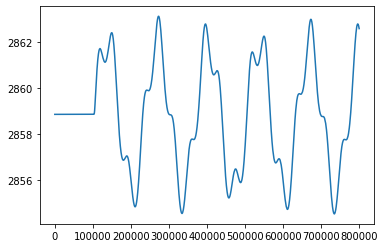

In [49]:
plt.plot(x_detecs_array[:,0])

In [50]:
x_detec[-1]

2862.6047538220155

In [51]:
x_detecs_array[-1,0]

2862.6047538220155

Analysis has started...
Memorizing the waveform at detector0...


'[1/m]'

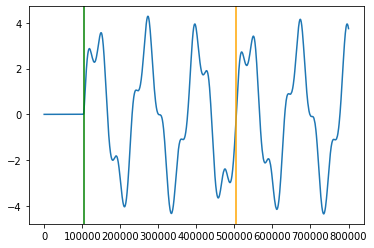

In [52]:
Ns_f1 = T_f1/timestep  # Ns: Number of data points in one cycle
# N: Total Number of data points in thw windowed region
N_f1 = int(Nc_f1*Ns_f1)

Ns_f2 = T_f2/timestep  # Ns: Number of data points in one cycle
# N: Total Number of data points in thw windowed region
N_f2 = int(Nc_f2*Ns_f2)

Ns_fgcd = T_fgcd/timestep
N_fgcd = int(Nc_fgcd*Ns_fgcd)

if(N_f1 != N_f2 or N_f2 != N_fgcd or N_fgcd != N_f1):
    print("REVIEW YOUR INPUT. Program has gone into forced shutdown.")
    sys.exit()

u_detecs_array = x_detecs_array - x_detecs_array[0]

delta_x_source_detec0 = x_detecs_array[0, 0] - x_source[0]
if detecs_num >= 2:
    delta_x_detecs = x_detecs_array[0, 1] - x_detecs_array[0, 0]
    delta_t_detecs = delta_x_detecs/10*(10**3)/5500  # ps
trimmed_waves = np.zeros((detecs_num, N_fgcd))
windowed_waves = np.zeros((detecs_num, N_fgcd))
wave_velocity_at_detecs_array = np.zeros(detecs_num)
zerocross_timestep_at_detecs_array = np.zeros(detecs_num)
arrival_timestep_at_detecs_array = np.zeros(detecs_num)

print("Analysis has started...")
for i in range(detecs_num):
    print("Memorizing the waveform at detector"+str(i)+"...")
    x_detec = x_detecs_array[:, i]
    u_detec = u_detecs_array[:, i]
    delta_x_source_to_thisdetec = x_detec[0] - x_source[0]
    if "zerocross_start_rate" in config:
        zerocross_timestep, arrival_timestep, wave_velocity = fu.wave_arrival_zerocross(
            u_detec, delta_x_source_to_thisdetec, v_expt, timestep, T_fgcd, float(config["zerocross_start_rate"]))
    else:
        zerocross_timestep, arrival_timestep, wave_velocity = fu.wave_arrival_zerocross(
            u_detec, delta_x_source_to_thisdetec, v_expt, timestep, T_fgcd)
    wave_velocity_at_detecs_array[i] = wave_velocity
    zerocross_timestep_at_detecs_array[i] = zerocross_timestep
    arrival_timestep_at_detecs_array[i] = arrival_timestep
    plt.plot(u_detec)
    plt.axvline(x=zerocross_timestep, color="orange")
    plt.axvline(x=arrival_timestep, color="green")
    plt.savefig("waveform.png")

wave_velocity = wave_velocity_at_detecs_array[-1]
del zerocross_timestep
del arrival_timestep

wavelength_f1 = wave_velocity * T_f1 * (10**(-12))
"""[m]"""
wavelength_f2 = wave_velocity * T_f2 * (10**(-12))
"""[m]"""
k_f1 = 2*np.pi/wavelength_f1
"""[1/m]"""
k_f1 = 2*np.pi/wavelength_f1
"""[1/m]"""

In [53]:
x_detecs_array[-1,0]

2862.6047538220155

In [54]:
# フーリエ変換
for i in range(detecs_num):
    # ゼロクロス法の音速測定
    # Δx_source_and_detec[A]*100[pm/A] / v[pm/ps] = Δt_source_and_detec [ps]
    # この時刻から半周期たった時（first positive peak）を基準に，そこからゼロクロス法を行う
    print("Transforming the waveform at the detector "+str(i)+"...")
    x_detec = x_detecs_array[:, i]
    u_detec = u_detecs_array[:, i]
    delta_x_source_to_thisdetec = x_detec[0] - x_source[0]

    window_start_timestep = int(
        zerocross_timestep_at_detecs_array[i] - 2*T_f2/timestep)


    # ここまで音速測定

    trimmedWave = u_detec[window_start_timestep:window_start_timestep+N_fgcd]
    trimmedTime = time[window_start_timestep:window_start_timestep+N_fgcd]

    windowedWave = fu.window(trimmedWave)
    #paddedWave = fu.zeroPadding(windowedWave)
    #paddedWaveWithoutWindow = fu.zeroPadding(trimmedWave)

    ##SUPER IMPORTANT##
    waveToTransform = windowedWave
    ##CHOU DAIJI##

    """if (i==detecs_num-2):
        plt.plot(time, u_detec)
        plt.axvline(x=window_start_timestep*timestep)
        plt.axvline(x=(window_start_timestep+N_fgcd)*timestep)
        plt.show()"""

    # FFT. transformedArray: [0]=power, [1]=freq
    # FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
    #FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
    ffted_data = fu.FFTonly(waveToTransform, timestep)
    #FFTedData=FFTonly(window(trimmedWave, "hann"))
    abs_ffted_data = np.abs(ffted_data)

    index_fsum = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fsum*10**9)
    A_fsum = abs_ffted_data[0][index_fsum]
    a_fsum = A_fsum*2/int(len(waveToTransform))*10**-10
    a_fsum_at_detecs[i] = a_fsum

    index_fdif = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_fdif*10**9)
    A_fdif = abs_ffted_data[0][index_fdif]
    a_fdif = A_fdif*2/int(len(waveToTransform))*10**-10
    a_fdif_at_detecs[i] = a_fdif

    index_f1 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][index_f1]
    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    index_f2 = fu.getIndexOfNearestValue(abs_ffted_data[1], freq_f2*10**9)
    A_f2 = abs_ffted_data[0][index_f2]
    a_f2 = A_f2 * 2/int(len(waveToTransform))*10**-10
    a_f2_at_detecs[i] = a_f2

    beta_mix = fu.getBetaFreqMix(a_fsum, a_fdif, source_amp_f1*10**-10, source_amp_f2*10**-10,
                                 freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity)
    beta_mix_corrected = fu.getBetaFreqMix(
        a_fsum, a_fdif, a_f1, a_f2, freq_f1*10**9, freq_f2*10**9, delta_x_source_to_thisdetec*10**-10, wave_velocity_at_detecs_array[i])

    beta_sum = beta_mix[0]
    beta_sum_corrected = beta_mix_corrected[0]
    beta_sums_at_detecs[i] = beta_sum
    beta_sums_at_detecs_corrected[i] = beta_sum_corrected

    beta_dif = beta_mix[1]
    beta_dif_corrected = beta_mix_corrected[1]
    beta_difs_at_detecs[i] = beta_dif
    beta_difs_at_detecs_corrected[i] = beta_dif_corrected

    # higher harmonics amplitude[arb]
    harmonicsIndex = fu.getIndexUpToSixthHarmonic(
        abs_ffted_data[1], freq_f1*10**9)
    A_f1 = abs_ffted_data[0][harmonicsIndex[0]]
    A_2f1 = abs_ffted_data[0][harmonicsIndex[1]]
    A_3f1 = abs_ffted_data[0][harmonicsIndex[2]]
    A_4f1 = abs_ffted_data[0][harmonicsIndex[3]]
    A_5f1 = abs_ffted_data[0][harmonicsIndex[4]]
    A_6f1 = abs_ffted_data[0][harmonicsIndex[5]]

    a_f1 = A_f1*2/int(len(waveToTransform))*10**-10
    a_f1_at_detecs[i] = a_f1

    a_2f1 = A_2f1*2/int(len(waveToTransform))*10**-10
    a_2f1_at_detecs[i] = a_2f1

    a_3f1 = A_3f1*2/int(len(waveToTransform))*10**-10
    a_3f1_at_detecs[i] = a_3f1

    a_4f1 = A_4f1*2/int(len(waveToTransform))*10**-10
    a_4f1_at_detecs[i] = a_4f1

    a_f1_source = source_amp_f1*10**-10
    a_f2_source = source_amp_f2*10**-10

    beta_shg = fu.getBetaSHG(a_f1_source, a_2f1, wavelength_f1,
                             delta_x_source_to_thisdetec*(10**-10))
    beta_shg_corrected = fu.getBetaSHG(
        a_f1, a_2f1, wavelength_f1, delta_x_source_to_thisdetec*(10**-10))
    """with open("betaSHG.txt", "w") as f:
        f.write(str(betaSHG))
    """
    beta_SHGs_at_detecs[i] = beta_shg
    beta_SHGs_at_detecs_corrected[i] = beta_shg_corrected

    """if i == detecs_num-3:
        fig, ax = plt.subplots()
        ax.plot(trimmedTime, waveToTransform)
        plt.savefig("wave_of_detector_"+str(i)+".png", format="png")"""

Transforming the waveform at the detector 0...


Drawing the graphs at the right end detector...
beta_slope_sum
1.2419498663332036

beta_slope_dif
1.4121655135050348

average
1.327057689919119


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


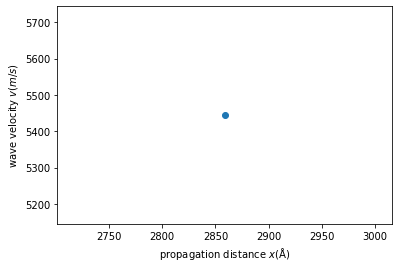

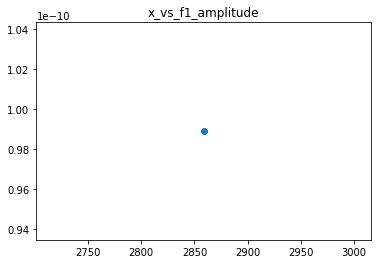

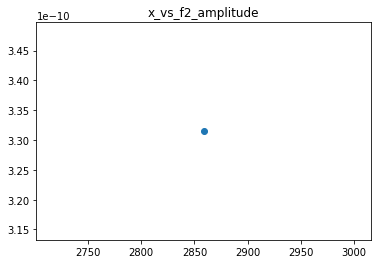

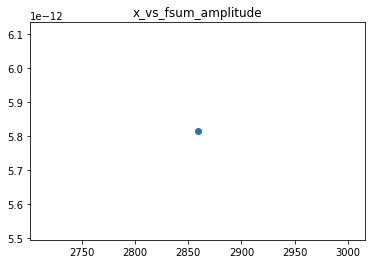

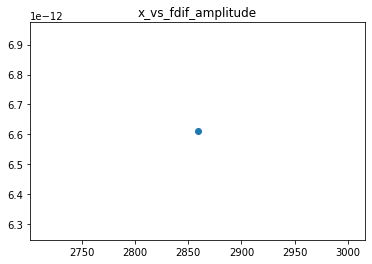

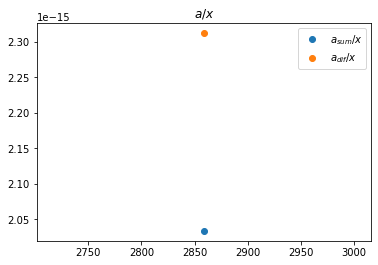

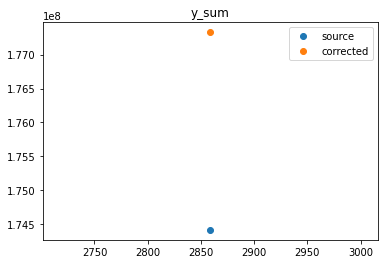

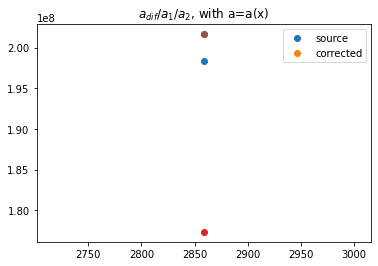

In [55]:
print("Drawing the graphs at the right end detector...")
beta_aves_at_detecs = (beta_sums_at_detecs + beta_difs_at_detecs)/2
beta_aves_at_detecs_corrected = (
    beta_sums_at_detecs_corrected + beta_difs_at_detecs_corrected)/2

fig, ax = plt.subplots()
ax.set_xlabel(r"propagation distance $x (\mathrm{\AA)}$ ")
ax.set_ylabel(r"wave velocity $v (m/s)$")
ax.plot(x_detecs_array[0], wave_velocity_at_detecs_array,
        marker="o", linestyle="none")
plt.savefig("x_vs_velocity.png")

fig, ax = plt.subplots()
title = "x_vs_f1_amplitude"
plt.plot(x_detecs_array[0, :], a_f1_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_f2_amplitude"
plt.plot(x_detecs_array[0, :], a_f2_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_fsum_amplitude"
plt.plot(x_detecs_array[0, :], a_fsum_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")

fig, ax = plt.subplots()
title = "x_vs_fdif_amplitude"
plt.plot(x_detecs_array[0, :], a_fdif_at_detecs, marker="o", linestyle="none")
plt.title(title)
plt.savefig(title+".png")


fig, ax = plt.subplots()
ax.set_title("$a/x$")
ax.plot(x_detecs_array[0, :], a_fsum_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none", label=r"$a_{sum}/x$")
ax.plot(x_detecs_array[0, :], a_fdif_at_detecs /
        x_detecs_array[0, :], marker="o", linestyle="none", label=r"$a_{dif}/x$")
ax.legend()
plt.savefig("x_vs_a.png")


# slope method
y_sum_source = a_fsum_at_detecs/a_f1_source/a_f2_source
fig, ax = plt.subplots()
ax.plot(x_detecs_array[0, :], y_sum_source[:],
        marker="o", linestyle="none", label="source")

y_sum_corrected = a_fsum_at_detecs/a_f1_at_detecs/a_f2_at_detecs
ax.plot(x_detecs_array[0, :], y_sum_corrected[:],
        marker="o", linestyle="none", label="corrected")
title = "y_sum"
ax.set_title(title)
ax.legend()
plt.savefig(title+".png")

fig, ax = plt.subplots()
y_dif_source = a_fdif_at_detecs/a_f1_source/a_f2_source
ax.plot(x_detecs_array[0, :], y_dif_source[:],
        marker="o", linestyle="none", label="source")

y_dif_corrected = a_fdif_at_detecs/a_f1_at_detecs/a_f2_at_detecs
ax.plot(x_detecs_array[0, :], y_dif_corrected[:],
        marker="o", linestyle="none", label="corrected")
title = "y_dif"
ax.set_title(title)
ax.legend()
plt.savefig(title+".png")
# detector 0からM-1 が外れ値をとっている場合がある．その場合N以降でslopeを取ったほうが良い．
# 外れていない場合は M=0

N = 0
res_sum = np.polyfit(
    x_detecs_array[0, N:], y_sum_corrected[N:], 1)
linear = np.poly1d(res_sum)(x_detecs_array[0, N:])
plt.plot(x_detecs_array[0, N:], linear)
plt.plot(x_detecs_array[0, N:], y_sum_corrected[N:],
         marker="o", linestyle="none")
plt.title("$a_{sum}/a_1/a_2$, with a=a(x)")
plt.savefig("ysum_linear_fit.png")
# print(res_sum[0])
beta_slope_sum = res_sum[0]*4*wavelength_f1*wavelength_f2*10**10/4/np.pi**2
print("beta_slope_sum")
print(beta_slope_sum)
print()
with open("beta.csv", mode='a') as f:
    f.write(str(beta_slope_sum))

M = 0
res_dif = np.polyfit(
    x_detecs_array[0, M:], y_dif_corrected[M:], 1)
linear = np.poly1d(res_dif)(x_detecs_array[0, M:])
plt.plot(x_detecs_array[0, M:], linear)
plt.plot(x_detecs_array[0, M:], y_dif_corrected[M:],
         marker="o", linestyle="none")
plt.title("$a_{dif}/a_1/a_2$, with a=a(x)")
plt.savefig("ydif_linear_fit.png")
# print(res_dif[0])
beta_slope_dif = res_dif[0]*4*wavelength_f1*wavelength_f2*10**10/4/np.pi**2
print("beta_slope_dif")
print(beta_slope_dif)
print()
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_slope_dif))

print("average")
beta_slope_ave = (beta_slope_dif+beta_slope_sum)/2
print(beta_slope_ave)
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_slope_ave))

beta_sum_rightend_detec, corrected
2.484419574782069
beta_sum_rightend_detec, raw
2.443652327657578
beta_ave_rightend_detec, corrected
2.654670845478063
beta_ave_rightend_detec, raw
2.6111099174084638
beta_dif_rightend_detec, corrected
2.8249221161740565
beta_ave_rightend_detec, raw
2.77856750715935


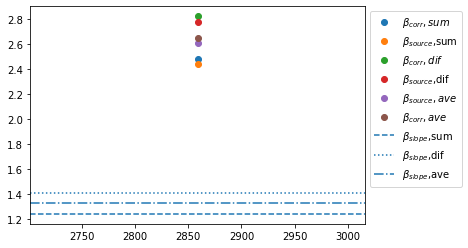

In [56]:
print("beta_sum_rightend_detec, corrected")
print(beta_sums_at_detecs_corrected[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_sums_at_detecs_corrected[-1]))

with open("beta_sum_corr.txt", mode="w") as f:
    f.write(str(beta_sums_at_detecs_corrected[-1]))

print("beta_sum_rightend_detec, raw")
print(beta_sums_at_detecs[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_sums_at_detecs[-1]))

print("beta_ave_rightend_detec, corrected")
print((beta_difs_at_detecs_corrected[-1]+beta_sums_at_detecs_corrected[-1])/2)
with open("beta.csv", mode='a') as f:
    f.write(
        ","+str((beta_difs_at_detecs_corrected[-1]+beta_sums_at_detecs_corrected[-1])/2))

print("beta_ave_rightend_detec, raw")
print((beta_sums_at_detecs[-1]+beta_difs_at_detecs[-1])/2)
with open("beta.csv", mode='a') as f:
    f.write(","+str((beta_sums_at_detecs[-1]+beta_difs_at_detecs[-1])/2))

print("beta_dif_rightend_detec, corrected")
print(beta_difs_at_detecs_corrected[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_difs_at_detecs_corrected[-1]))

print("beta_ave_rightend_detec, raw")
print(beta_difs_at_detecs[-1])
with open("beta.csv", mode='a') as f:
    f.write(","+str(beta_difs_at_detecs[-1]))

fig, ax = plt.subplots()

ax.plot(x_detecs_array[0, :], beta_sums_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},sum$")
ax.plot(x_detecs_array[0, :], beta_sums_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,sum")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},dif$")
ax.plot(x_detecs_array[0, :], beta_difs_at_detecs, marker="o",
        linestyle="none", label=r"$\beta_{source}$,dif")
ax.plot(x_detecs_array[0, :], beta_aves_at_detecs,
        marker="o", linestyle="none", label=r"$\beta _{source},ave$")
ax.plot(x_detecs_array[0, :], beta_aves_at_detecs_corrected,
        marker="o", linestyle="none", label=r"$\beta _{corr},ave$")
ax.axhline(y=beta_slope_sum, linestyle="--",
           label=r"$\beta _{slope}$,sum")
ax.axhline(y=beta_slope_dif, linestyle=":",
           label=r"$\beta _{slope}$,dif")
ax.axhline(y=beta_slope_ave, linestyle="dashdot",
           label=r"$\beta _{slope}$,ave")
# ax.set_xlim([400,699])
#ax.set_ylim([2, 3.5])
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("betas_vs_x.png", bbox_inches="tight")